## Jupyter Notebook visualizing generated data

### This code is incapsulated into module datagen.py

In [1]:
import numpy as np
np.random.seed(42)

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def __generate_cube__(center, width):
    """Makes point equally distributed in hyper-cuboid

    Keyword arguments:
    center -- array, contains multi-dim coord
    width -- array, countains width in corresponding dims
    """
    cntr = np.array(center)
    wdth = np.array(width)
    point = np.random.rand(*cntr.shape)
    return point * wdth  + cntr - wdth / 2.

def __generate_cube_n__(center, width):
    """Makes point normally distributed in hyper-cuboid

    Keyword arguments:
    center -- array, contains multi-dim coord
    width -- array, countains width in corresponding dims
    """
    cntr = np.array(center)
    wdth = np.array(width)
    point = cntr + np.minimum(wdth*1.1, wdth * np.random.randn())
    return point

def __generate_sphere__(center, r):
    """Makes point equally distributed in hyper-cuboid

    Keyword arguments:
    center -- array, contains multi-dim coord
    r -- radius
    """
    #if it's 1D sphere, there's no need to use separate algo
    if len(center) == 1:
        return __generate_cube__(center, [r])
    #to avoid repeats while generate, let's turn to polar coordinates
    cntr = np.array(center)
    #initialize output array with radius of random point in sphere
    point = np.zeros(cntr.shape) + np.random.rand() * r
    #polar coords
    alphas = np.random.rand(len(center)-1) * 2 * np.pi
    #calculate decard coords by formula
    for i in range(len(center)-1):
        point[0] *= np.sin(alphas[i])
        
    for i in range(1, len(center)):
        point[i] *= np.cos(alphas[i-1])
        for j in range(i, len(center) - 1):
            point[i] *= np.sin(alphas[j])
            
    return point + cntr

def __generate_sphere_n__(center, r):
    """Makes point normally distributed in hyper-cuboid

    Keyword arguments:
    center -- array, contains multi-dim coord
    r -- radius
    """
    #if it's 1D sphere, there's no need to use separate algo
    if len(center) == 1:
        return __generate_cube__(center, [r])
    #to avoid repeats while generate, let's turn to polar coordinates
    cntr = np.array(center)
    #initialize output array with radius of random point in sphere
    point = np.zeros(cntr.shape) + min(r , np.random.randn() * r)
    #polar coords
    alphas = np.random.rand(len(center)-1) * 2 * np.pi
    #calculate decard coords by formula
    for i in range(len(center)-1):
        point[0] *= np.sin(alphas[i])
        
    for i in range(1, len(center)):
        point[i] *= np.cos(alphas[i-1])
        for j in range(i, len(center) - 1):
            point[i] *= np.sin(alphas[j])
            
    return point + cntr

def __pick_direction__(num_dims):
    point = np.ones(num_dims)
    #polar coords
    alphas = np.random.rand(len(point)-1) * 2 * np.pi
    #calculate decard coords by formula
    for i in range(len(point)-1):
        point[0] *= np.sin(alphas[i])
        
    for i in range(1, len(point)):
        point[i] *= np.cos(alphas[i-1])
        for j in range(i, len(point) - 1):
            point[i] *= np.sin(alphas[j])
    return point

def __has_intersection__(array, element, minimal):
    for other in array:
        if __dist__(other[0], element) < minimal:
            return True
    return False

def __dist__(x,y):   
    return np.sqrt(np.sum((x-y)**2))

def generate_data(num_classes, num_examples, num_features, separable, dist_ratio):
    """Makes dataset of points with certain conditions

    Keyword arguments:
    num_classes -- number of different classes in set. (num of clouds)
    num_examples -- number of examples in total. (classes are distibuted ~equally)
    num_features -- number of features of each example. (coodinates)
    separable -- True if points are linear-separable and False otherwise
    dist_ratio -- ratio between distance between the others and average size of each point-cloud (d/r)
    """
    SHAPES = ['sphere']#, 'sphere_n', 'cube']#, 'cube_n']
    SCALE = 100.
    type_of_clouds = []
    cloud_params = []
    result = []
    labels = []
    for _ in range(num_classes):
        type_of_clouds.append(np.random.choice(SHAPES))
    #hard-code, but it's ok
    type_of_clouds[0] = 'sphere'
    initial_center = np.random.randn(num_features) * SCALE / 2.
    R = 2 * SCALE / num_classes
    dist = dist_ratio * R
    cloud_params.append((initial_center, R))
    for _ in range(num_classes):
        refer_not_found = True
        while(refer_not_found):
            refer = np.random.randint(0, len(cloud_params))
            newR = np.clip(np.random.randn() * R, 0.9 * R, 1.1 * R)
            dist_to_refer = dist * 1.0 + newR
            newCenter = __pick_direction__(num_features) * dist_to_refer + cloud_params[refer][0]
            if separable:
                if __has_intersection__(cloud_params, newCenter, dist_to_refer * 0.8 ):
                    continue
            else:
                if __has_intersection__(cloud_params, newCenter, dist_to_refer * 0.4 ):
                    continue
            second_param = newR
            if type_of_clouds[refer] == 'cube' or type_of_clouds[refer] == 'cube_n':
                 second_param = newR + (np.random.rand(num_features) - 0.5) * R * 0.1
            cloud_params.append((newCenter, second_param))
            refer_not_found = False
    
    for _ in range(num_examples):
        cloud = np.random.randint(0, num_classes)
        if type_of_clouds[cloud] == 'sphere':
            result.append(__generate_sphere__(*cloud_params[cloud]))
        elif type_of_clouds[cloud] == 'sphere_n':
             result.append(__generate_sphere_n__(*cloud_params[cloud]))
        elif type_of_clouds[cloud] == 'cube':
             result.append(__generate_cube__(*cloud_params[cloud]))
        elif type_of_clouds[cloud] == 'cube_n':
             result.append(__generate_cube_n__(*cloud_params[cloud]))
        labels.append(cloud)
    return(np.array(result), np.array(labels))

**TOFIX: Only equally-distributed points inside spheres are used**

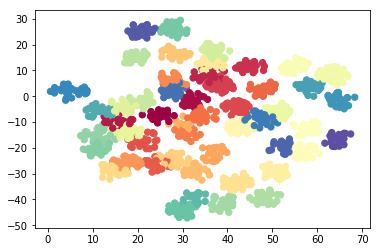

In [3]:
X, y = generate_data(50, 1700, 2, False, 1.5)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()